## Analysis

The analysis of the acquired data can be done with the ```analysis.ipynb``` notebook.
The analysis notebook consists on several steps:
1. Loading of the data: both oscilloscope screens and time data from a path string.
1. Plotting of all osciloscope screens.
1. Counting the peaks by taking the derivative of the signal and detecting when that derivative exceeds a certain threshold.
1. Calculating the histogram: since each bin has been measured a different amount of times, each frequency of each bin of the histogram made with numpy histogram is then normalized for the amount of times that bin has been measured.
This is done by dividing by the output of ```calc_normalization_factor```, which outputs the amount of times the bin with left edge $t_l$ and right edge $t_r$ has bin measured by inputting the time $t$ of the bin edges.
For some bins, a time $t_{change}$ lies in the middle of them, where for $t < t_{change}$ and $t > t_{change}$ the bin has been measured a different amount of times.
The correction $f'$ for the frequency $f$ of those bins is the following $$f' = f \times \left[F_l \frac{(t_{change} - t_l)}{(t_r - t_l)} + F_r \frac{(1 -(t_{change} - t_l))}{(t_r - t_l)}\right]^{-1}$$. A binomial erorr is assigned to each bin.
1. Plotting the histogram and erorrbars.
1. Fit exponential an lineal.
1. Plot histogram heights and fit.


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import glob

In [48]:
%matplotlib widget

In [49]:
#osc.decimation=32768
#osc.trigger_post=11444
#osc.trigger_pre=0
#osc.trig_src=8
#osc.get_measurement_time()=2.999975936
#osc.amount_datapoints=11444

# Load data

In [55]:
common_path = '/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/'
times_path = f"{common_path}times*"
amount_windows = 5
screens_windows_path = []
for w in range(amount_windows):
    screens_windows_path.append(glob.glob(f"{common_path}w{w}*"))
times_paths = glob.glob(times_path)
print(times_paths)
print(screens_windows_path)

['/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/times_w0.npy', '/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/times_w1.npy', '/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/times_w2.npy', '/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/times_w3.npy', '/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/times_w4.npy']
[['/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/w0b52ol0.5_3.0.npy', '/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/w0b49ol0.5_3.0.npy', '/home/tomi/Documents/facultad/tesis/horibaPTI-controller/calibration/rp_decay/data/rp-decay/exp2_standalone/w0b22ol0

# Plot data

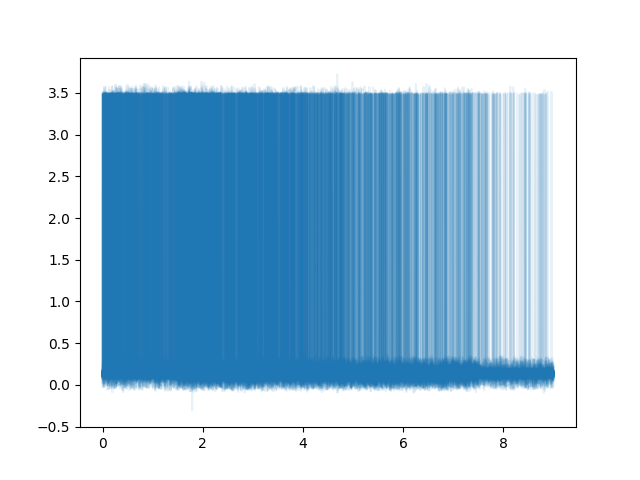

In [56]:
plt.close('all')
for time_path, screen_window_path in zip(times_paths, screens_windows_path):
    time = np.load(time_path)
    for screen_path in screen_window_path:
        screen = np.load(screen_path)
        plt.plot(time, screen, alpha=0.1, color='C0')

plt.show()

# Count where the peaks are

In [57]:
def count_peaks(data, threshold=2):
    times, screen = data
    return times[1:][np.diff(screen) > threshold]

def count_peaks_from_paths(time_paths, screen_window_paths):
    counts = np.array([])
    for time_path, screen_window_path in zip(time_paths, screen_window_paths):
        time = np.load(time_path)
        for screen_path in screen_window_path: 
            screen = np.load(screen_path)
            peaks = count_peaks((time, screen))
            counts = np.hstack((counts, peaks))
    return counts

counts = count_peaks_from_paths(times_paths, screens_windows_path)

# Calculate bins, and histogram, and histogram error

In [109]:
def get_measurement_intervals(common_path):
    times_path = glob.glob(f"{common_path}times*")
    times = [np.load(path) for path in times_path]
    mes_intervals = []
    for time in times:
        mes_intervals.append((time[0], time[-1]))
    return mes_intervals

def calc_normalization_factor(t, mes_intervals, overlap):
    t0, tf = mes_intervals[0][0], mes_intervals[-1][1]
    wwith = mes_intervals[0][1] - t0
    count = 0
    for start in np.arange(t0, tf - wwith, wwith - overlap * wwith):
        end = start + wwith if start + wwith < tf else tf
        condition = np.logical_and(start <= t, t < end)
        count += condition.astype(int)
    return count

def find_time_of_change(t_left, t_right, mes_intervals, overlap):
    times = np.linspace(t_left, t_right, 1000)
    factors = calc_normalization_factor(times, mes_intervals, overlap)
    derivative = np.diff(factors)
    value = np.where(np.logical_or(derivative > 0.5, derivative < -0.5))[0]
    return times[value][0]

def normalized_histogram(counts, bins, mes_intervals, overlap):
    freq, bin_edges = np.histogram(counts, density=True, bins=bins)

    t_left = bins[0]
    for i, t_right in enumerate(bin_edges[1:]):
        factor_left = calc_normalization_factor(t_left, mes_intervals, overlap)
        factor_right = calc_normalization_factor(t_right, mes_intervals, overlap)
        if factor_left == factor_right:
            freq[i] = freq[i]/factor_left
        else:
            t_change_relative = find_time_of_change(t_left, t_right, mes_intervals, overlap) - t_left
            width = t_right - t_left
            pct_factor_left = t_change_relative/width
            pct_factor_right = 1 - t_change_relative/width
            freq[i] = freq[i] / (pct_factor_left * factor_left + pct_factor_right * factor_right)
        t_left = t_right
    return freq

intervals = get_measurement_intervals(common_path)
overlap = 0.5
bins = np.linspace(0, 9, 80)
freq = normalized_histogram(counts, bins, intervals, overlap)
error = np.sqrt(freq)/np.sqrt(len(counts))

# Plot Histogram

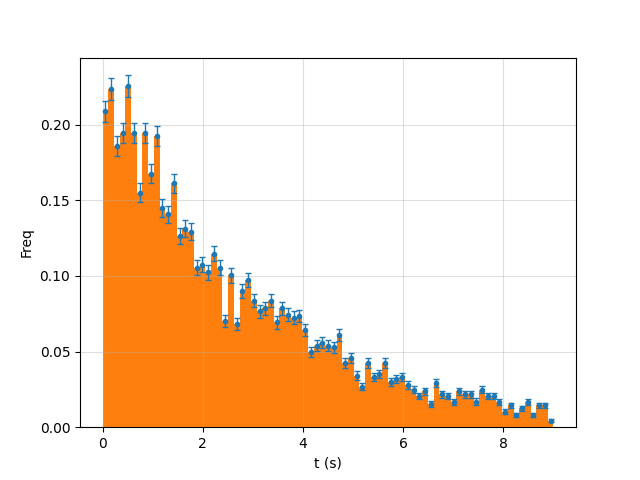

In [111]:
bin_centres = bins[1:] - (bins[1] - bins[0])/2
plt.close('all')
plt.grid(alpha=0.4)
plt.stairs(freq, bins, fill=True, color="C1")
plt.errorbar(bin_centres, freq, yerr=error,
             fmt='o', markersize=3, linewidth=1, capsize=2)
plt.ylabel("Freq")
plt.xlabel("t (s)")
plt.show()

# Fit exponential and lineal

In [119]:

def expon(x, a, t):
    return a*np.exp(-x/t)

p0 = [1.0, 4.0]
popt, pcov = curve_fit(expon, bin_centres, freq, p0, sigma=error)
a, t = popt
aerr, terr = np.sqrt(np.diag(pcov))
print(a,t)
print(pcov)

0.23007212771698096 2.890282972265813
[[ 3.22980521e-05 -2.72826394e-04]
 [-2.72826394e-04  4.00697094e-03]]


# Plot fit and data

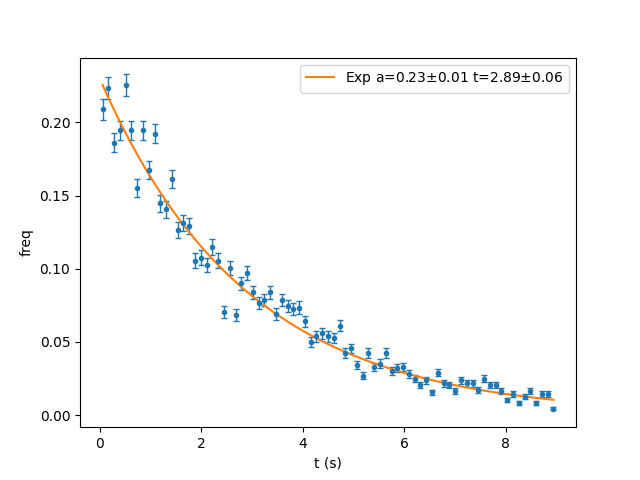

In [120]:
plt.close('all')
plt.errorbar(bin_centres, freq, yerr=error,
             fmt='o', markersize=3, linewidth=1, capsize=2)
plt.plot(bin_centres, expon(bin_centres, a,t ), label=f"Exp a={a:.2f}$\pm${aerr:.2f} t={t:.2f}$\pm${terr:.2f}")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("freq")
plt.show()